<font size=6> <b> 3주차 강의 Notebook </b> </font>
<div class="alert alert-block alert-success">
 이번 시간에는, 지난 강의에 이어 Pandas의 아래와 같은 고급 기능에 대해 알아본다. <br>
 주요 내용: visualization, profiling, join/merge, pivot/pivot_table, apply/applymap, etc.<br>
</div>
<p style="text-align:right;"> sumyeon@gmail.com </p>

 <hr>

# 필요한 모듈/패키지를 import

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

<b> Appendix의 EDA 자동화 tool용 import. 문제 발생시 무시하고 진행해도 됨 </b>

In [10]:
# pandas-profiling 설치 필요
import os
import pandas_profiling
import webbrowser

<b> 가끔씩 발생하는 warning message들의 출력을 막는 기능 (Optional) </b>

In [2]:
import warnings
warnings.filterwarnings("ignore")

 <hr>

# Data loading

In [11]:
os.chdir('d:/jupyternotebook/python_anal_atoz')

In [12]:
# read csv file into data frame (main memory)
airdf = pd.read_csv('seoul_air_polution.csv')
airdf.columns = ['date','loc','NO2','O3','CO','SO2','PM10','PM2.5']

In [13]:
parkdf = pd.read_csv('seoul_greenpark.tsv', sep='\t')
parkdf.columns = ['loc','total_area','park_area','park_ratio']

# 필요없는 Index, Column 삭제

<b> Index 값을 지정해서 해당 row를 삭제 </b>

In [14]:
airdf.drop(1).head(2)

,date,loc,NO2,O3,CO,SO2,PM10,PM2.5
0,20171009,강남구,0.024,0.020,0.4,0.007,28.0,22.0
2,20171009,중구,0.031,0.025,0.5,0.005,25.0,18.0


<b> index 범위를 지정해서 해당 row를 삭제 </b>

In [15]:
airdf.drop(airdf.index[0:100]).head(2)

,date,loc,NO2,O3,CO,SO2,PM10,PM2.5
100,20171007,강남구,0.02,0.018,0.3,0.004,7.0,5.0
101,20171007,도산대로,0.03,0.018,1.0,0.004,15.0,6.0


<b> 컬럼을 지정해서 해당 컬럼을 삭제 (= 해당 컬럼을 제외한 나머지 컬럼을 선택) </b>

In [16]:
airdf.drop('CO', axis=1).head(2)

,date,loc,NO2,O3,SO2,PM10,PM2.5
0,20171009,강남구,0.024,0.020,0.007,28.0,22.0
1,20171009,한강대로,0.037,0.019,0.006,32.0,16.0


<div class="alert alert-block alert-warning">
<b> Note:</b> 위의 모든 operation은 원본 dataframe을 변경하지 않음. 필요한 작업 결과는 저장하거나, "inplace=True" 옵션을 사용해야함 </b>
</div>

In [17]:
airdf.head(2)

,date,loc,NO2,O3,CO,SO2,PM10,PM2.5
0,20171009,강남구,0.024,0.020,0.4,0.007,28.0,22.0
1,20171009,한강대로,0.037,0.019,0.5,0.006,32.0,16.0


# Filter를 사용하는 Selection 방법

In [18]:
# select columns using column name
airdf.filter(items=['CO','NO2']).head(2)

,CO,NO2
0,0.4,0.024
1,0.5,0.037


In [19]:
airdf.filter(regex='O.+').head(2)

,NO2,O3,SO2
0,0.024,0.020,0.007
1,0.037,0.019,0.006


In [20]:
airdf.filter(like='O').head(2)

,NO2,O3,CO,SO2
0,0.024,0.020,0.4,0.007
1,0.037,0.019,0.5,0.006


<div class="alert alert-block alert-info">
<b> Tip:</b> filter는 Series의 경우 index에, Dataframe의 경우 columns에 적용됨. 필요한 경우, axis=0/1 으로 지정 가능 </b>
</div>

# Colum 조건에 따라 새로운 column값 구하는 법

## Where문 사용 : if true first value else second value

In [21]:
# select columns using column values
airdf['district'] = airdf['loc'].where( airdf['loc'].str.contains('구'), other = '별도측정소')

In [22]:
airdf.head(5)

,date,loc,NO2,O3,CO,SO2,PM10,PM2.5,district
0,20171009,강남구,0.024,0.020,0.4,0.007,28.0,22.0,강남구
1,20171009,한강대로,0.037,0.019,0.5,0.006,32.0,16.0,별도측정소
2,20171009,중구,0.031,0.025,0.5,0.005,25.0,18.0,중구
3,20171009,마포구,0.021,0.031,0.4,0.006,22.0,19.0,마포구
4,20171009,광진구,0.041,0.026,0.8,0.006,25.0,19.0,광진구


<div class="alert alert-block alert-info">
<b> Tip:</b> Series의 where가 아닌, numpy의 where 도 있음. 전자의 경우 조건이 True인 경우 원래 자신의 값인 반면 np.where는 True/False 모두 값을 지정</b> 
<pre> np.where(condition, A, B) = A.where(condition, B) </pre>
</div>

## Apply/ApplyMap : 함수를 사용해서 조건에 맞는 값을 선택

<b> 단순한 True/False를 넘어서 복잡한 로직에 따른 값을 선택하고 싶다 </b> </br>
<b> 예) PM2.5 값에 따라 4가지 레벨 ('좋음','보통','나쁨','아주나쁨')을 값을 dataframe에 추가 하고 싶다! </b>

### PM2.5값에 따라 4가지 레벨을 리턴하는 함수

In [23]:
def pm25tolevel(value):
    """ PM2.5 값에 따른 4단계 분류 값을 리턴"""
    if value <= 15:
        return 'good'
    elif value <= 50:
        return 'normal'
    elif value <= 100:
        return 'bad'
    else:
        return 'verybad'

### Apply 함수 : Series/Dataframe에 적용 가능

<b> PM2.5의 값을 레벨로 변환하여 'pm25_level' 컬럼에 저장 </b>

In [24]:
# 'PM2.5'가 lambda 함수의 'value'인자로 전달됨
airdf['pm25_level'] = airdf['PM2.5'].apply(lambda value : pm25tolevel(value) )

In [25]:
airdf.head(2)

,date,loc,NO2,O3,CO,SO2,PM10,PM2.5,district,pm25_level
0,20171009,강남구,0.024,0.020,0.4,0.007,28.0,22.0,강남구,normal
1,20171009,한강대로,0.037,0.019,0.5,0.006,32.0,16.0,별도측정소,normal


<b> PM10과 PM2.5의 두 가지 모두 verybad 레벨일 경우 'worst'라는 컬럼에 True로 저장 </b>

In [26]:
# 'PM2.5'가 lambda 함수의 'value'인자로 전달됨
airdf['worst'] = airdf.apply(lambda row : True if row['PM2.5'] > 100 and row['PM10'] > 150 else False, axis=1)

In [27]:
airdf.head(5)

,date,loc,NO2,O3,CO,SO2,PM10,PM2.5,district,pm25_level,worst
0,20171009,강남구,0.024,0.020,0.4,0.007,28.0,22.0,강남구,normal,False
1,20171009,한강대로,0.037,0.019,0.5,0.006,32.0,16.0,별도측정소,normal,False
2,20171009,중구,0.031,0.025,0.5,0.005,25.0,18.0,중구,normal,False
3,20171009,마포구,0.021,0.031,0.4,0.006,22.0,19.0,마포구,normal,False
4,20171009,광진구,0.041,0.026,0.8,0.006,25.0,19.0,광진구,normal,False


<div class="alert alert-block alert-info">
<b> Tip:</b> Apply 기능은, Series일 경우 하나의 개별 value에, Dataframe의 경우 개별 row에 함수를 적용</b>
</div>

In [28]:
airdf['PM2.5'].map(lambda value : pm25tolevel(value) ).head(5)

0    normal
1    normal
2    normal
3    normal
4    normal
Name: PM2.5, dtype: object

In [29]:
airdf.applymap(lambda value : True).head(5)

,date,loc,NO2,O3,CO,SO2,PM10,PM2.5,district,pm25_level,worst
0,True,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,True


In [30]:
airdf.head(2)

,date,loc,NO2,O3,CO,SO2,PM10,PM2.5,district,pm25_level,worst
0,20171009,강남구,0.024,0.020,0.4,0.007,28.0,22.0,강남구,normal,False
1,20171009,한강대로,0.037,0.019,0.5,0.006,32.0,16.0,별도측정소,normal,False


<div class="alert alert-block alert-info">
<b> Tip:</b> map (for Series), applymap (for Dataframe)은 elementwise로 함수를 적용하고 결과를 전달 </b>
</div>

# Data Frame merge, join

<b> 끝 부분에서, 다음 가설을 확인해 보려 합니다. => 녹지가 많은 지역의 대기 오염도가 낮은 걸 아닐까? </b> (DBMS의 Join) <br>
<b> 가설 확인을 위해서, 대기오염 정보 dataframe과 공원녹지 정보 dataframe을 연결 해야함! </b>



<table>
  <tr>
      <th> airdf </th>
      <th> -------- </th>
      <th> parkdf </th>
  </tr>
  <tr>
      <td> <pre>
|    |     date | loc      |   NO2 |    O3 |   CO |   SO2 |   PM10 |   PM2.5 |
|---:|---------:|:---------|------:|------:|-----:|------:|-------:|--------:|
|  0 | 20171009 | 강남구   | 0.024 | 0.02  |  0.4 | 0.007 |     28 |      22 |
|  1 | 20171009 | 한강대로 | 0.037 | 0.019 |  0.5 | 0.006 |     32 |      16 |
|  2 | 20171009 | 중구     | 0.031 | 0.025 |  0.5 | 0.005 |     25 |      18 |
|  3 | 20171009 | 마포구   | 0.021 | 0.031 |  0.4 | 0.006 |     22 |      19 |
|  4 | 20171009 | 광진구   | 0.041 | 0.026 |  0.8 | 0.006 |     25 |      19 |
          </pre>
      </td> 
      <td> </td>
      <td>
      <pre>
|    | loc    | total_area   | park_area   |   park_ratio |
|---:|:-------|:-------------|:------------|-------------:|
|  0 | 합계   | 605,196,566  | 168,843,299 |        27.9  |
|  1 | 종로구 | 23,912,883   | 11,555,792  |        48.32 |
|  2 | 중구   | 9,960,930    | 3,131,968   |        31.44 |
|  3 | 용산구 | 21,866,844   | 1,795,641   |         8.21 |
|  4 | 성동구 | 16,860,100   | 3,102,064   |        18.4  |
 </pre>
      </td>
    </tr>
</table>
    

## Merge 명령어로 column(s)을 공유하는 두 dataframe을 병합!

In [31]:
airdf.merge(parkdf, on='loc', how='left').head()

,date,loc,NO2,O3,CO,SO2,PM10,PM2.5,district,pm25_level,worst,total_area,park_area,park_ratio
0,20171009,강남구,0.024,0.020,0.4,0.007,28.0,22.0,강남구,normal,False,"39,501,308","6,591,655",16.69
1,20171009,한강대로,0.037,0.019,0.5,0.006,32.0,16.0,별도측정소,normal,False,NaN,NaN,NaN
2,20171009,중구,0.031,0.025,0.5,0.005,25.0,18.0,중구,normal,False,"9,960,930","3,131,968",31.44
3,20171009,마포구,0.021,0.031,0.4,0.006,22.0,19.0,마포구,normal,False,"23,843,621","4,439,901",18.62
4,20171009,광진구,0.041,0.026,0.8,0.006,25.0,19.0,광진구,normal,False,"17,063,230","3,363,048",19.71


In [32]:
pd.merge(airdf, parkdf, on='loc', how='left').head()

,date,loc,NO2,O3,CO,SO2,PM10,PM2.5,district,pm25_level,worst,total_area,park_area,park_ratio
0,20171009,강남구,0.024,0.020,0.4,0.007,28.0,22.0,강남구,normal,False,"39,501,308","6,591,655",16.69
1,20171009,한강대로,0.037,0.019,0.5,0.006,32.0,16.0,별도측정소,normal,False,NaN,NaN,NaN
2,20171009,중구,0.031,0.025,0.5,0.005,25.0,18.0,중구,normal,False,"9,960,930","3,131,968",31.44
3,20171009,마포구,0.021,0.031,0.4,0.006,22.0,19.0,마포구,normal,False,"23,843,621","4,439,901",18.62
4,20171009,광진구,0.041,0.026,0.8,0.006,25.0,19.0,광진구,normal,False,"17,063,230","3,363,048",19.71


<div class="alert alert-block alert-info">
<b> Tip:</b> merge 함수에서 두 Dataframe의 join column이 다른 경우, left_on='loc', right_on='loc'와 같이 직접 join key를 지정해 주면 된다. </b> <br>
<b> Tip:</b> join 시에 left, right, outer 등의 방식 선정은 how='left'와 같은 방식으로 지정해 주면 된다. </b>
</div>

## Join 명령어로 index가 같은 두 dataframe을 병합!

In [33]:
airdf.set_index('loc').join(parkdf.set_index('loc'), how='left').head()

,date,NO2,O3,CO,SO2,PM10,PM2.5,district,pm25_level,worst,total_area,park_area,park_ratio
loc,,,,,,,,,,,,,
강남구,20171009,0.024,0.020,0.4,0.007,28.0,22.0,강남구,normal,False,"39,501,308","6,591,655",16.69
강남구,20171008,0.022,0.020,0.4,0.005,16.0,12.0,강남구,good,False,"39,501,308","6,591,655",16.69
강남구,20171007,0.020,0.018,0.3,0.004,7.0,5.0,강남구,good,False,"39,501,308","6,591,655",16.69
강남구,20171006,0.013,0.020,0.3,0.004,10.0,5.0,강남구,good,False,"39,501,308","6,591,655",16.69
강남구,20171005,0.013,0.021,0.3,0.004,13.0,6.0,강남구,good,False,"39,501,308","6,591,655",16.69


<div class="alert alert-block alert-info">
<b> Tip:</b> join함수는 index가 같은 두 Dataframe을 병합하는데 사용됨
</div>

In [34]:
mergedf = airdf.merge(parkdf, on='loc', how='left')

# Pivot/Pivot_table

<b> 엑셀의 Pivot과 유사한 기능을 제공. </b>

In [35]:
pd.pivot(airdf, index='date', columns='loc', values='PM10').head(5)

loc,강남구,강남대로,강동구,강변북로,강북구,강서구,공항대로,관악구,광진구,구로구,...,정릉로,종로,종로구,중구,중랑구,천호대로,청계천로,한강대로,홍릉로,화랑로
date,,,,,,,,,,,,,,,,,,,,,
20161009,19.0,25.0,20.0,21.0,12.0,19.0,23.0,23.0,17.0,19.0,...,22.0,20.0,15.0,NaN,19.0,22.0,16.0,28.0,19.0,21.0
20161010,29.0,38.0,32.0,35.0,20.0,31.0,56.0,30.0,24.0,30.0,...,31.0,25.0,25.0,NaN,29.0,24.0,25.0,40.0,28.0,35.0
20161011,48.0,56.0,48.0,52.0,36.0,42.0,70.0,45.0,42.0,48.0,...,45.0,24.0,44.0,NaN,46.0,33.0,41.0,59.0,41.0,50.0
20161012,60.0,68.0,63.0,64.0,49.0,57.0,75.0,54.0,55.0,57.0,...,60.0,33.0,50.0,NaN,59.0,48.0,48.0,69.0,51.0,63.0
20161013,45.0,55.0,54.0,52.0,34.0,52.0,71.0,43.0,41.0,46.0,...,44.0,31.0,37.0,NaN,46.0,39.0,36.0,60.0,39.0,54.0


<b> Pivot table은 pivot의 indx/columns 가 하나 이상의 column일때도 가능. 추가로, pivot은 중복되는 item 항목이 있을 경우 에러 발생 </b>

In [36]:
pd.pivot_table(airdf, index='loc', columns='pm25_level', values='PM2.5', aggfunc=[np.mean]).head()

mean                              
pm25_level        bad       good     normal verybad
loc                                                
강남구         60.833333  10.494949  28.173554   107.0
강남대로        63.473684  10.800000  28.391061     NaN
강동구         60.875000  10.572727  28.379310     NaN
강변북로        62.560000  10.500000  28.217391     NaN
강북구         60.437500   9.669355  27.659193     NaN

# Multi-level indexing

In [37]:
mdf = airdf.reset_index().set_index(['date','loc'])

In [38]:
mdf.head()

index    NO2     O3   CO    SO2  PM10  PM2.5 district  \
date     loc                                                           
20171009 강남구       0  0.024  0.020  0.4  0.007  28.0   22.0      강남구   
         한강대로      1  0.037  0.019  0.5  0.006  32.0   16.0    별도측정소   
         중구        2  0.031  0.025  0.5  0.005  25.0   18.0       중구   
         마포구       3  0.021  0.031  0.4  0.006  22.0   19.0      마포구   
         광진구       4  0.041  0.026  0.8  0.006  25.0   19.0      광진구   

              pm25_level  worst  
date     loc                     
20171009 강남구      normal  False  
         한강대로     normal  False  
         중구       normal  False  
         마포구      normal  False  
         광진구      normal  False

In [39]:
mdf.index[:5]

MultiIndex([(20171009,  '강남구'),
            (20171009, '한강대로'),
            (20171009,   '중구'),
            (20171009,  '마포구'),
            (20171009,  '광진구')],
           names=['date', 'loc'])

# Multi-level Index <-> Multi-level Column을 변환

In [40]:
mdf.unstack().head()

index                                                          \
loc         강남구   강남대로    강동구   강변북로    강북구    강서구   공항대로    관악구    광진구   
date                                                                      
20161009  14264  14250  14245  14237  14268  14267  14248  14270  14247   
20161010  14202  14225  14219  14232  14217  14222  14206  14203  14229   
20161011  14190  14159  14182  14169  14187  14176  14172  14189  14174   
20161012  14147  14134  14137  14140  14121  14118  14138  14145  14127   
20161013  14088  14081  14113  14091  14108  14105  14115  14110  14098   

                 ...  worst                                                   \
loc         구로구  ...    정릉로     종로    종로구     중구    중랑구   천호대로   청계천로   한강대로   
date             ...                                                           
20161009  14269  ...  False  False  False  False  False  False  False  False   
20161010  14218  ...  False  False  False  False  False  False  False  False   
20161011  14164  ...  False  False  False  False  False  False  False  False   
20161012  14136  ...  False  False  False  False  False  False  False  False   
20161013  14086  ...  False  False  False  False  False  False  False  False   

                        
loc         홍릉로    화랑로  
date                    
20161009  False  False  
20161010  False  False  
20161011  False  False  
20161012  False  False  
20161013  False  False  

[5 rows x 390 columns]

In [41]:
mdf.unstack().stack()

index    NO2     O3   CO    SO2  PM10  PM2.5 district  \
date     loc                                                           
20161009 강남구   14264  0.013  0.026  0.3  0.004  19.0   10.0      강남구   
         강남대로  14250  0.044  0.017  0.5  0.005  25.0   11.0    별도측정소   
         강동구   14245  0.012  0.028  0.3  0.003  20.0    9.0      강동구   
         강변북로  14237  0.021  0.022  0.3  0.003  21.0    9.0    별도측정소   
         강북구   14268  0.013  0.028  0.3  0.002  12.0    6.0      강북구   
...              ...    ...    ...  ...    ...   ...    ...      ...   
20171009 천호대로     14  0.037  0.012  0.6  0.005  35.0   20.0    별도측정소   
         청계천로     17  0.036  0.018  0.5  0.007  30.0   20.0    별도측정소   
         한강대로      1  0.037  0.019  0.5  0.006  32.0   16.0    별도측정소   
         홍릉로      27  0.041  0.016  0.5  0.006  33.0   22.0    별도측정소   
         화랑로      38  0.034  0.009  0.6  0.004  32.0   17.0    별도측정소   

              pm25_level  worst  
date     loc                     
20161009 강남구        good  False  
         강남대로       good  False  
         강동구        good  False  
         강변북로       good  False  
         강북구        good  False  
...                  ...    ...  
20171009 천호대로     normal  False  
         청계천로     normal  False  
         한강대로     normal  False  
         홍릉로      normal  False  
         화랑로      normal  False  

[14274 rows x 10 columns]

#  Visualization

<b> 각 행정구역의 PM10, PM2.5 트렌드를 그래프로 확인! </b>

In [42]:
graphdf = airdf.groupby('loc').agg(pm25=('PM2.5','mean'), pm10=('PM10','mean'))

## Dataframe에 plot 기능이 추가되어, 간단한 그래프는 직접 Dataframe에서 수행 가능

<b> Dataframe이나 Series에서 plot 함수를 호출 </b>

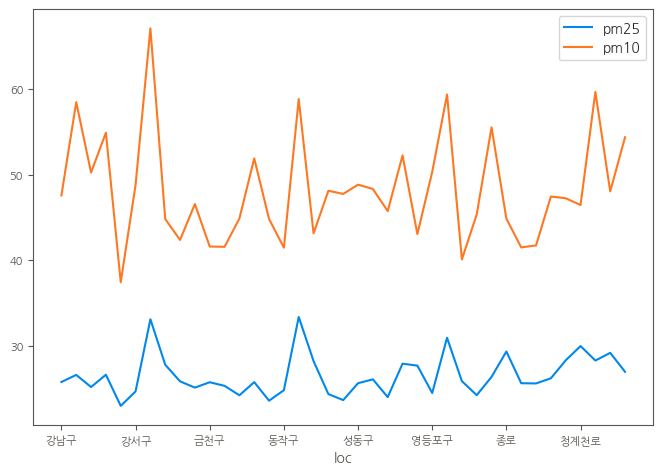

In [78]:
graphdf.plot()

## Matplot의 함수를 사용해서도 그래프 출력 가능

<b> plt.subplots 사용해서 fig,ax를 만들고, 이 바탕에 그래프를 출력 </b>

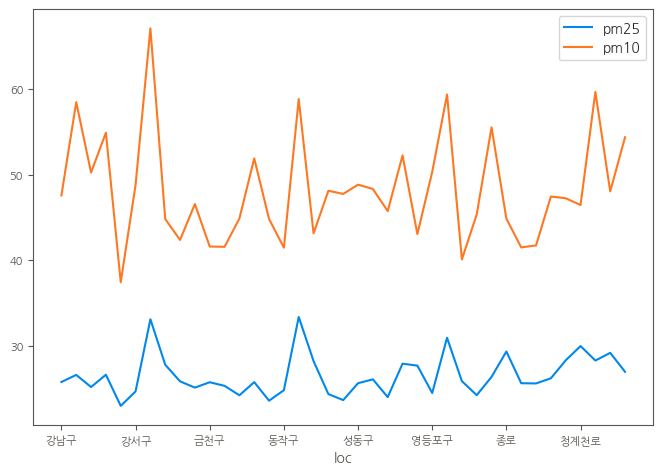

In [77]:
# without Hangul font-family settingkkk
fig, ax = plt.subplots()
graphdf.plot(ax=ax)  # default: kind='line'

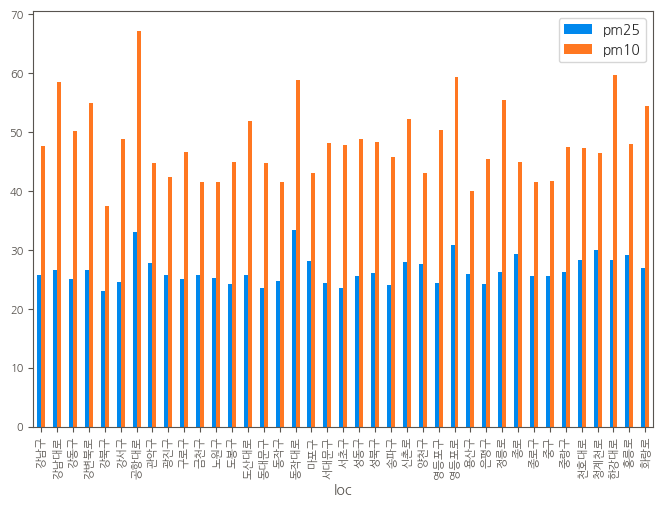

In [76]:
# without Hangul font-family settingkkk
fig, ax = plt.subplots()
graphdf.plot(kind='bar', ax=ax)

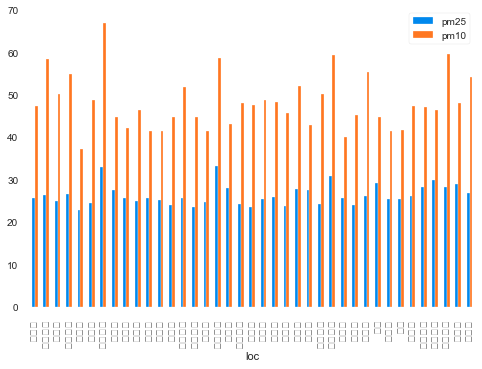

In [46]:
# without Hangul font-family settingkkk
fig, ax = plt.subplots()
graphdf.plot(kind='bar', ax=ax)

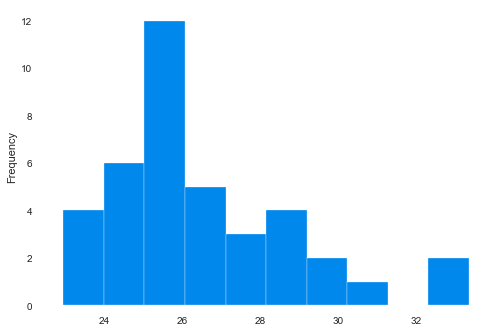

In [47]:
# without Hangul font-family settingkkk
fig, ax = plt.subplots()
graphdf['pm25'].plot(kind='hist', ax=ax)

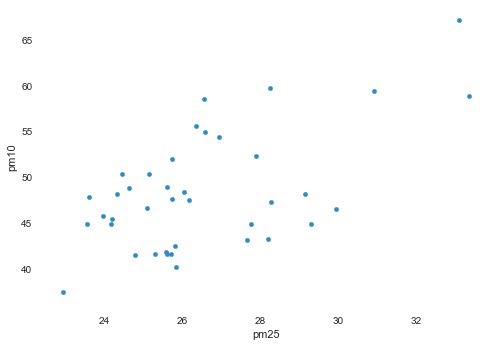

In [48]:
# without Hangul font-family settingkkk
fig, ax = plt.subplots()
graphdf.plot(kind='scatter', x='pm25', y='pm10', ax=ax)

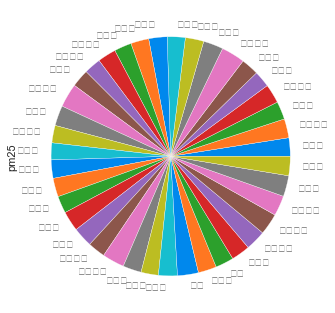

In [49]:
# without Hangul font-family settingkkk
fig, ax = plt.subplots()
graphdf['pm25'].plot(kind='pie', ax=ax)

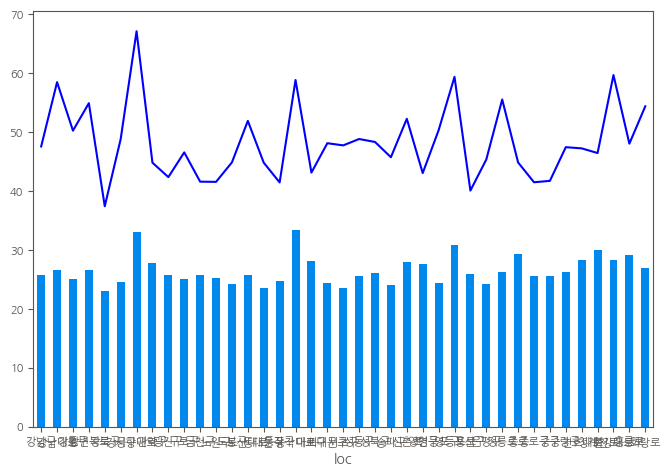

In [72]:
# without Hangul font-family settingkkk
fig, ax = plt.subplots()
graphdf['pm25'].plot(kind='bar', ax=ax)
graphdf['pm10'].plot(kind='line', ax=ax, color='blue')

<div class="alert alert-block alert-info">
<b> Tip:</b> 그래프이 개별 항목 조절이 가능하다. 아래는 matplotlib 그래프의 주요 항목 이름 <br>
    (From Practical Business Python by  Chris Moffitt)
</div>

<img src="http://pbpython.com/images/matplotlib-anatomy.png" />

<div class="alert alert-block alert-info">
<b> Tip: </b> 그래프를 출력하는 방법이 여러가지가 있음. 외부 article을 보아도 조금씩 다른 방식을 사용함. 개인적으로 pandas보다는 matplot 방식을 추천</b>
</div>

## 그래프에서 한글 깨짐을 방지 위한 한글 font 등록 방법
(아래 부분도 일단 외워두고, 한글이 깨지는 상황에는 무조건 적으로 사용!)

<b> step 1</b>: 먼저, 현재 시스템에 등록된 한글 폰트를 확인. <= 사용할 수 있는 폰트 목록 확인

In [51]:
import matplotlib.font_manager as fm
font_list = fm.findSystemFonts(fontpaths = None, fontext = 'ttf')
font_list[:10]

['C:\\WINDOWS\\Fonts\\ENBODBI.TTF',
 'C:\\WINDOWS\\Fonts\\HYWULM.TTF',
 'C:\\WINDOWS\\Fonts\\COPRGTB.TTF',
 'C:\\WINDOWS\\Fonts\\HYBDAL.TTF',
 'C:\\WINDOWS\\Fonts\\SitkaI.ttc',
 'C:\\Windows\\Fonts\\cambriai.ttf',
 'C:\\Windows\\Fonts\\GOTHICB.TTF',
 'C:\\Windows\\Fonts\\LCALLIG.TTF',
 'C:\\Windows\\Fonts\\Easop.ttf',
 'C:\\WINDOWS\\Fonts\\MOD20.TTF']

<b> step 2</b>: 폰트 경로를 통해, font family name을 확보 </b>

In [ ]:
font_name = fm.FontProperties(fname='C:\\WINDOWS\\Fonts\\HYWULM.TTF').get_name()
plt.rc('font', family=font_name)

<br>
<b>step 3 </b>: (방법 1) 현재 노트북 환경에 '나눔고딕' 한글 폰트를 등록. 새로운 노트북에 매번 동일 내용을 추가해야함
    

In [80]:
plt.rc('font', family='NanumGothic')

<br>
<b> step 3 </b>: (방법 2) matplotlib의 설정 파일 (matplotlibrc 파일)에 한글 폰트를 등록하는 방법. <br>
한번만 등록하면 새로운 노트북에서도 자동으로 설정이 적용됨 <br><br>

<pre>
matplotlibrc 파일에서 아래와 같이 내용을 변경

font.family : sans-serif  => font.family : NanumGothic
axes.unicode_minus: True  => axes.unicode_minus: False  
</pre>

한글 설정에 대한 상세/추가적인 내용은 https://m.blog.naver.com/itisik/221789012960 글 참조

## Matplot의 함수를 사용해서도 여러 개의 그래프(ax)를 하나의 fig에 출력

<b> plt 모듀의 subplots을 이용해서 fig, ax를 먼저 선언한 후 그래프 출력 </b>

[Text(0.5, 1.0, 'PM10')]

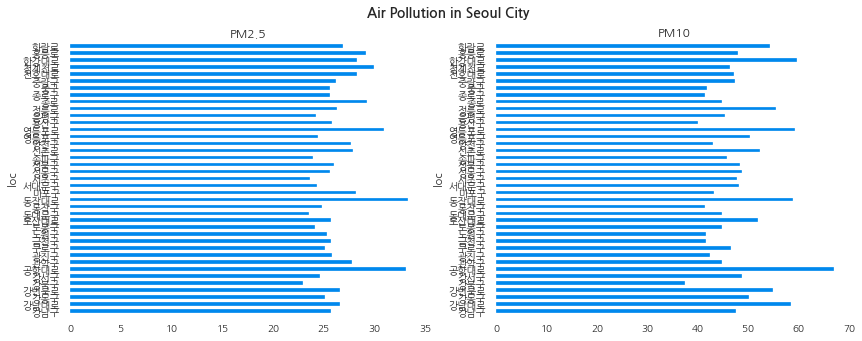

In [53]:
# prepare the canvas frame
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
# set the figure title
fig.suptitle('Air Pollution in Seoul City', fontsize=14, fontweight='bold')
# left (1st) sub-figure
graphdf['pm25'].plot(kind='barh', ax=ax0)
ax0.set(title='PM2.5')
# right (2nd) sub-figure
graphdf['pm10'].plot(kind='barh', ax=ax1)
ax1.set(title='PM10')

<img src="http://pbpython.com/images/matplotlib-pbpython-example-header.png" />

# 그 외

<b> 그래프를 표시하는 테마 자체를 설정 가능. 아래는, R에서 사용되는 ggplot 테마로 바꾸는 방법 </b>

In [54]:
# set the matplotlib default drawing style
plt.style.use('ggplot')                   # plt.style.available

[Text(0.5, 1.0, 'PM10')]

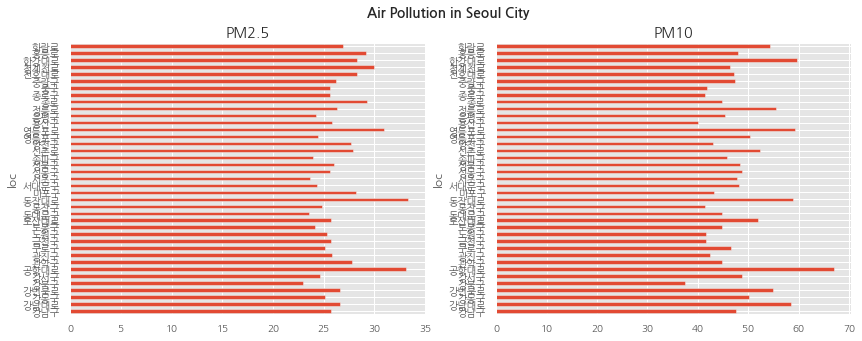

In [55]:
# prepare the canvas frame
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
# set the figure title
fig.suptitle('Air Pollution in Seoul City', fontsize=14, fontweight='bold')
# left (1st) sub-figure
graphdf['pm25'].plot(kind='barh', ax=ax0)
ax0.set(title='PM2.5')
# right (2nd) sub-figure
graphdf['pm10'].plot(kind='barh', ax=ax1)
ax1.set(title='PM10')

<b> 그래프를 화면에 표시하는 것 외에도, 이미지 파일로 저장 가능. 이미지 타입은 파일 확장자로부터 자동 선택 </b>

In [56]:
#
#  fig 작업을 수행
#
#
# save the figure into file
fig.savefig('piechart.png', dpi=125)

In [57]:
!dir

Active code page: 65001
 Volume in drive D is D30G
 Volume Serial Number is 701B-706E

 Directory of d:\jupyternotebook\python_anal_atoz

2020-08-04  �삤�썑 08:04    <DIR>          .
2020-08-04  �삤�썑 08:04    <DIR>          ..
2020-08-03  �삤�썑 10:07    <DIR>          .ipynb_checkpoints
2020-08-04  �삤�썑 08:04           479,078 advanced_pandas.ipynb
2020-08-01  �삤�썑 07:31         1,651,865 basic_pandas.ipynb
2020-08-04  �삤�쟾 12:40            31,739 financial_analysis.ipynb
2020-08-01  �삤�썑 07:31            46,474 jupyter_python.ipynb
2020-07-31  �삤�썑 11:42               764 new_result.csv
2020-08-04  �삤�썑 08:05            72,463 piechart.png
2020-08-03  �삤�썑 10:07           462,578 python_modules.ipynb
2020-08-03  �삤�썑 08:39               407 README.md
2020-08-03  �삤�썑 08:26         3,649,764 report.html
2017-10-09  �삤�썑 05:07           902,377 seoul_air_polution.csv
2020-08-01  �삤�쟾 08:17             1,043 seoul_greenpark.tsv
2020-07-29  �삤�썑 09:02         1,134,011 seoul_municipalities_g

# Appendix

<div class="alert alert-block alert-info">
<b> Tip:</b> 데이터에 대한 간략한 통계, 분포를 통한 EDA를 자동으로 report 해주는 모듈 </b>
</div>

In [73]:
report = airdf.profile_report()
report.to_file(output_file="report.html")

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\textpath.py:84: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)


In [59]:
webbrowser.open("report.html", new=0)

True

In [60]:
!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org sweetviz

Active code page: 65001


In [61]:
import sweetviz

In [83]:
analysis_report = sweetviz.analyze(airdf);
analysis_report.show_html();

:loc:                              |███▌                 | [ 17%]   00:00  -> (00:02 left)C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 51008 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 44396 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 50689 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 46321 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-p

Creating Associations graph... DONE!
Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: no browser will pop up, the report is saved in your notebook/colab files.


In [63]:
analysis_report = sweetviz.compare(airdf[airdf['loc'] == '중구'], airdf[airdf['loc'] == '구로구'])
analysis_report.show_html()

:loc:                              |███▌                 | [ 17%]   00:00  -> (00:04 left)C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 44396 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 47196 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 44396 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 47196 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packa

Creating Associations graph... DONE!
Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: no browser will pop up, the report is saved in your notebook/colab files.
